# **Project Objective: PJM Hourly Energy Consumption Forecasting**

The objective of this project is to analyze and forecast hourly energy consumption data for the PJM Interconnection, a regional transmission organization in the United States.

In [18]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
#load the dataset
df=pd.read_csv('/content/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [20]:
#convert to datetime and set datetime as index
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index(['Datetime'],inplace=True)

In [21]:
#create time-based features
df['hour']=df.index.hour
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year
df['weekday']=df.index.weekday #0 indicates monday
df['is_weekday']=df['weekday']>=5

#check for structure
print(df.head())

                     PJMW_MW  hour  day  month  year  weekday  is_weekday
Datetime                                                                 
2002-12-31 01:00:00   5077.0     1   31     12  2002        1       False
2002-12-31 02:00:00   4939.0     2   31     12  2002        1       False
2002-12-31 03:00:00   4885.0     3   31     12  2002        1       False
2002-12-31 04:00:00   4857.0     4   31     12  2002        1       False
2002-12-31 05:00:00   4930.0     5   31     12  2002        1       False


In [22]:
#check for null values
df.isnull().sum()

,0
PJMW_MW,0
hour,0
day,0
month,0
year,0
weekday,0
is_weekday,0


# **Data Visualisation**

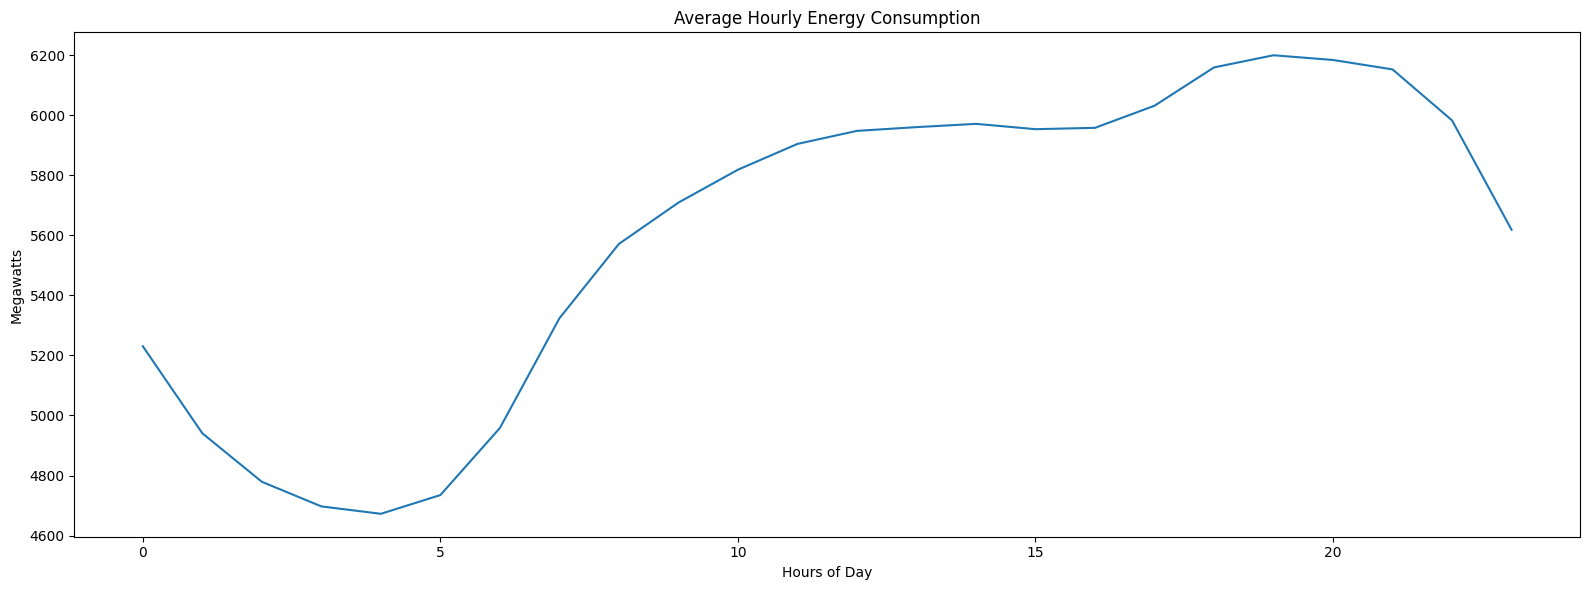

In [23]:
 #Average Hourly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='hour',y='PJMW_MW',data=df.groupby('hour')['PJMW_MW'].mean().reset_index())
plt.title("Average Hourly Energy Consumption")
plt.xlabel("Hours of Day")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

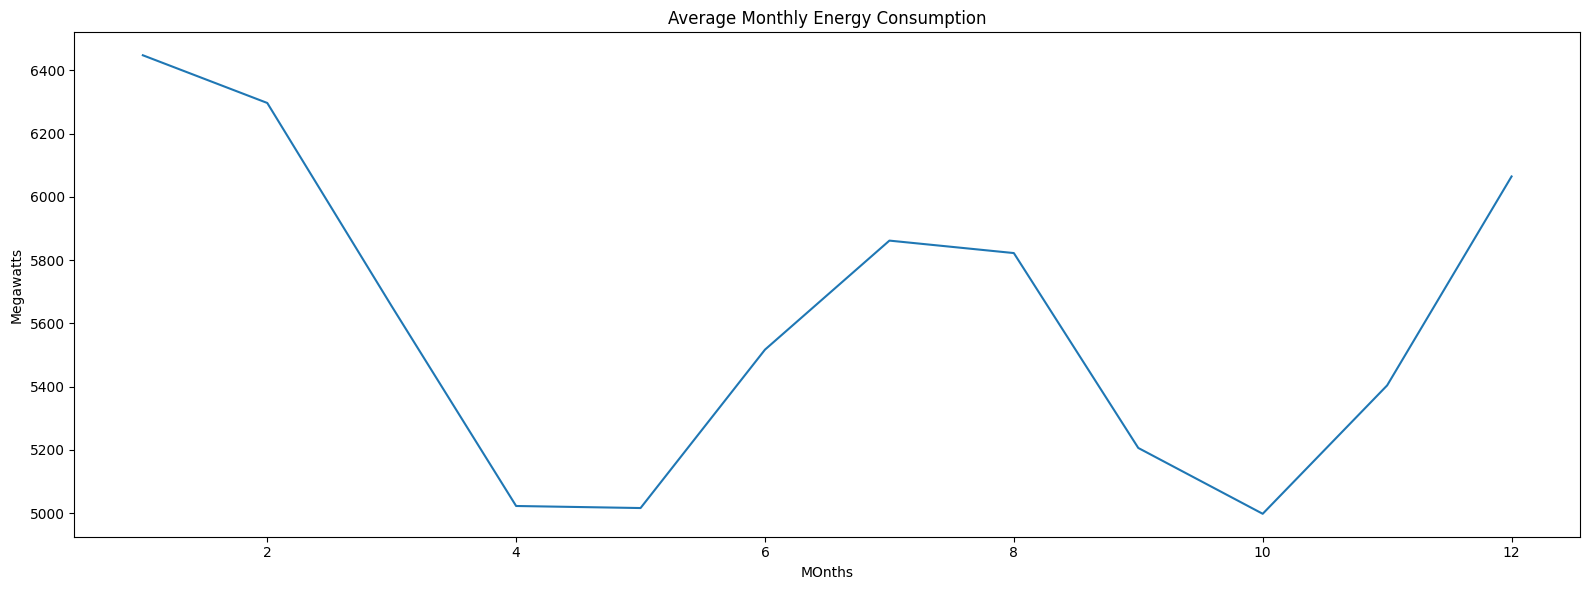

In [24]:
#Average Monthly Consumption
plt.figure(figsize=(16,6))
sns.lineplot(x='month',y='PJMW_MW',data=df.groupby('month')['PJMW_MW'].mean().reset_index())
plt.title("Average Monthly Energy Consumption")
plt.xlabel("MOnths")
plt.ylabel('Megawatts')
plt.tight_layout()
plt.show()

In [25]:
df.columns

Index(['PJMW_MW', 'hour', 'day', 'month', 'year', 'weekday', 'is_weekday'], dtype='object')

/tmp/ipython-input-26-2095508934.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')


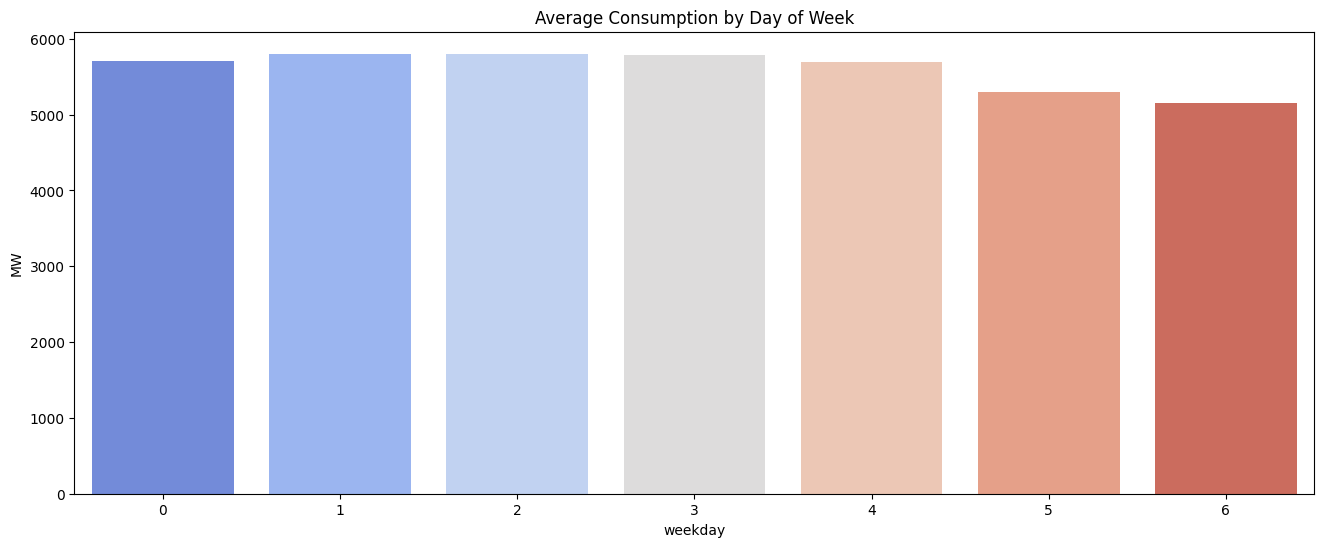

In [26]:
#Average Energy Consumption per days of week
plt.figure(figsize=(16,6))
sns.barplot(x='weekday',y='PJMW_MW',data=df.groupby('weekday')['PJMW_MW'].mean().reset_index(),palette='coolwarm')
plt.title('Average Consumption by Day of Week')
plt.ylabel('MW')
plt.show()

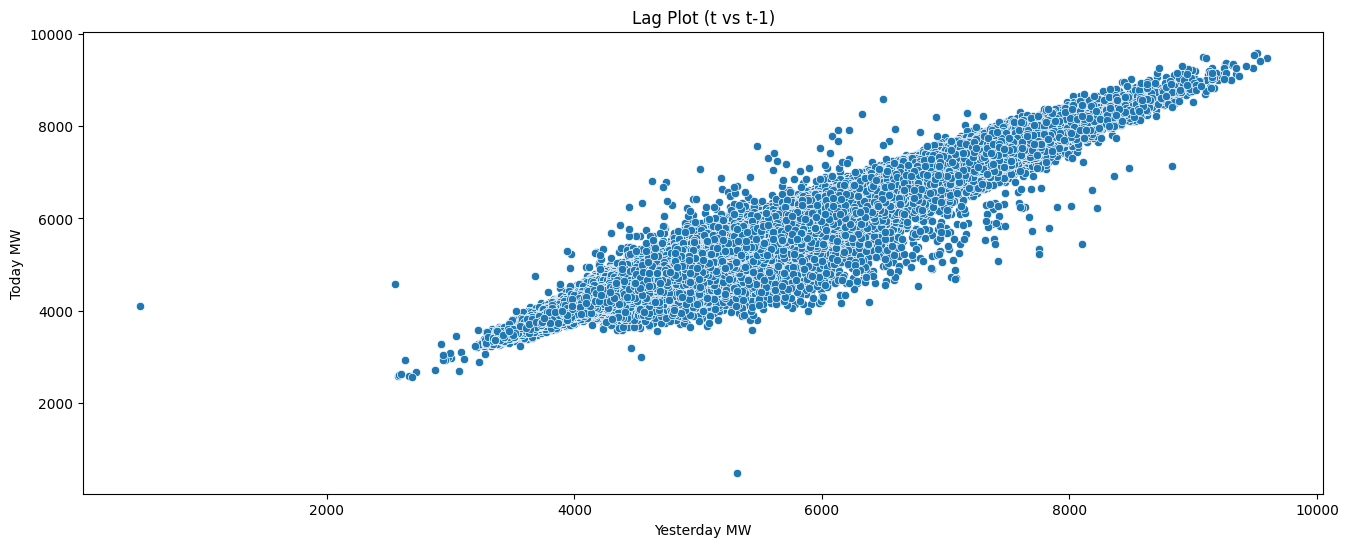

In [27]:
# Remove duplicate indices (keep first occurrence)
df = df[~df.index.duplicated(keep='first')]

plt.figure(figsize=(16, 6))
sns.scatterplot(x=df['PJMW_MW'].shift(1), y=df['PJMW_MW'])
plt.title('Lag Plot (t vs t-1)')
plt.xlabel('Yesterday MW')
plt.ylabel('Today MW')
plt.show()


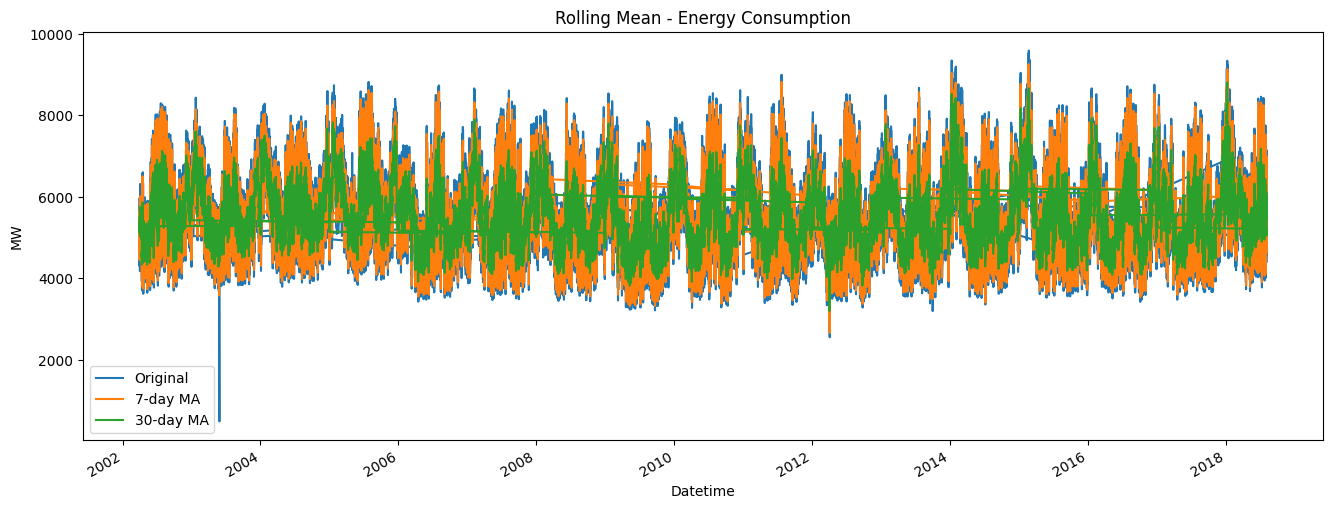

In [28]:
plt.figure(figsize=(16, 6))
df['PJMW_MW'].plot(label='Original')
df['PJMW_MW'].rolling(window=7).mean().plot(label='7-day MA')
df['PJMW_MW'].rolling(window=30).mean().plot(label='30-day MA')
plt.title('Rolling Mean - Energy Consumption')
plt.ylabel('MW')
plt.legend()
plt.show()


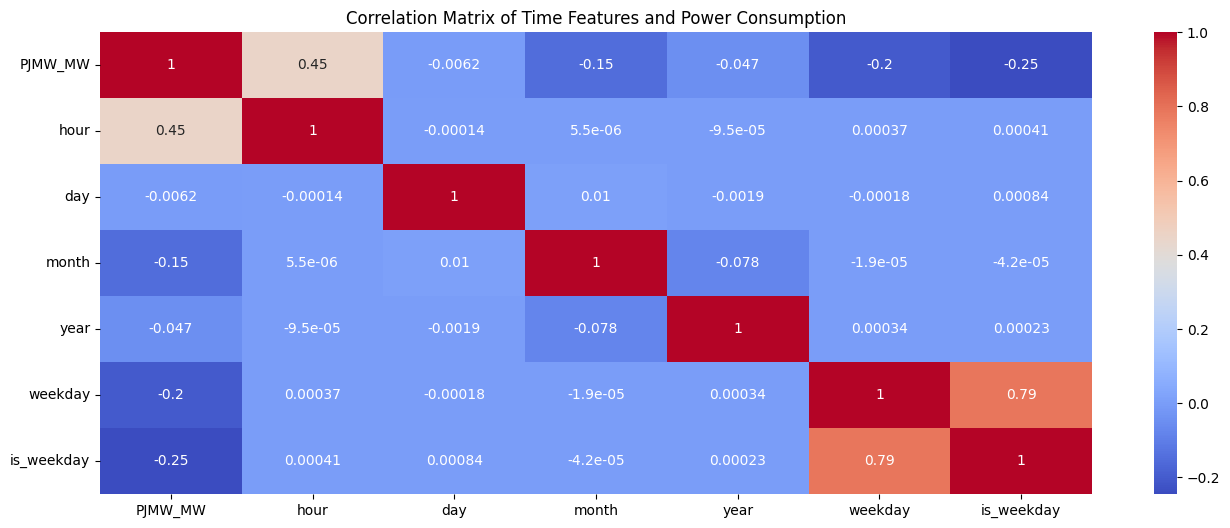

In [29]:
# Correlation Heatmap
# Displays relationships between time-based features and power usage
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.title("Correlation Matrix of Time Features and Power Consumption")
plt.show()

From the above correlation ,

we found that there is no multi-collinearity in the dataset .

# **Model Development and Forecasting**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

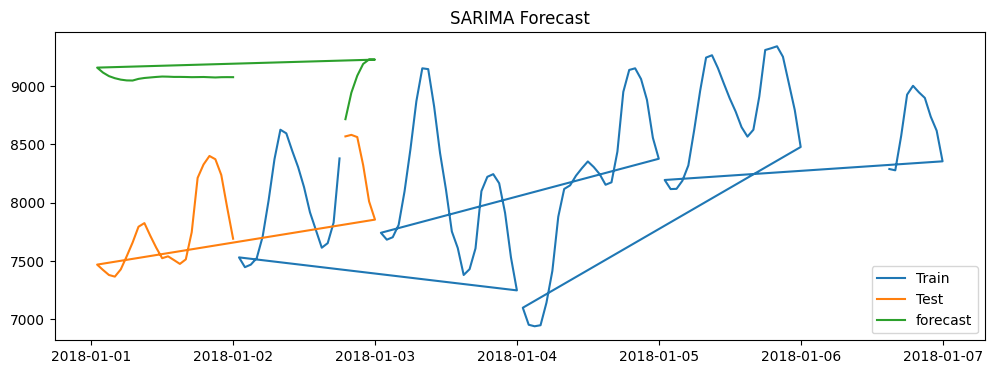

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

#split train-test set
train=df['PJMW_MW'].iloc[:-30] #select all the rows except last 30
test=df['PJMW_MW'].iloc[-30:]  #select last 30 rows

#train & fit SARIMA model
model=SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,7))
model_fit=model.fit(disp=False)

#forecast
forecast=model_fit.forecast(steps=30)
forecast.index=test.index

#plot
plt.figure(figsize=(12,4))
plt.plot(train[-100:],label="Train")
plt.plot(test,label="Test")
plt.plot(forecast,label="forecast")
plt.title("SARIMA Forecast")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - loss: 0.0041
Epoch 2/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 3.4114e-04
Epoch 3/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 66s 15ms/step - loss: 2.8994e-04
Epoch 4/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 2.6514e-04
Epoch 5/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 2.5945e-04
Epoch 6/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 2.4329e-04
Epoch 7/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 2.3329e-04
Epoch 8/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 2.3083e-04
Epoch 9/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 2.1652e-04
Epoch 10/10
4474/4474 ━━━━━━━━━━━━━━━━━━━━ 91s 16ms/step - loss: 2.1612e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


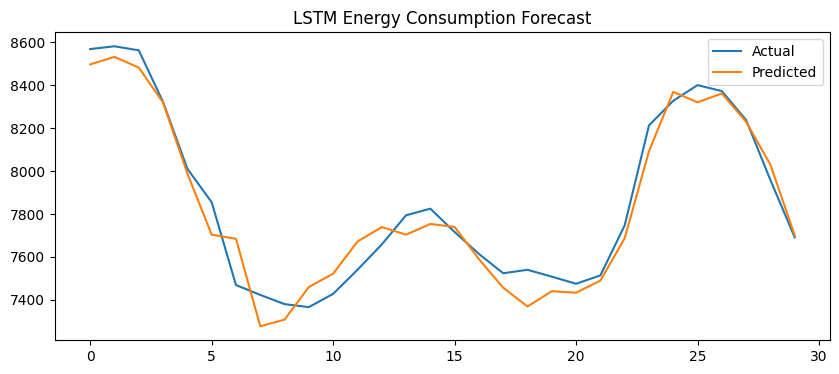

In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Use only the target column (assuming 'PJMW_MW')
target = df[['PJMW_MW']]

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target)

# Sequence builder
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Sequence length
seq_len = 30
X, y = create_sequences(scaled_data, seq_len)

# Split into train and test (last 30 points as test)
X_train, y_train = X[:-30], y[:-30]
X_test, y_test = X[-30:], y[-30:]

# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
X_test = X_test.reshape((X_test.shape[0], seq_len, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, verbose=1)

# Forecast
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Energy Consumption Forecast')
plt.legend()
plt.show()


XGBoost RMSE: 129.27


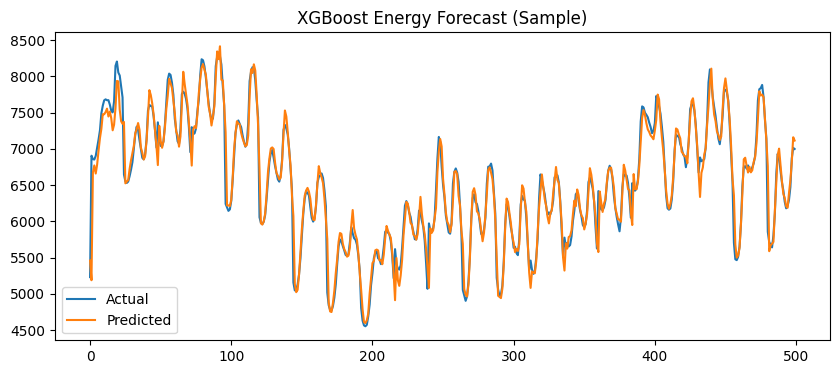

In [32]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Use only the target column
target = df[['PJMW_MW']].copy()

# Create lag features
for lag in range(1, 25):  # using 24 previous hours
    target[f'lag_{lag}'] = target['PJMW_MW'].shift(lag)

# Drop rows with NaN values due to lagging
target.dropna(inplace=True)

# Train-test split
train = target[target.index.year < 2017]
test = target[target.index.year == 2017]

X_train = train.drop('PJMW_MW', axis=1)
y_train = train['PJMW_MW']
X_test = test.drop('PJMW_MW', axis=1)
y_test = test['PJMW_MW']

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'XGBoost RMSE: {rmse:.2f}')

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_test.values[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.title('XGBoost Energy Forecast (Sample)')
plt.legend()
plt.show()
